# PREPARACION DE DATOS

## Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import unidecode
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Funciones

In [2]:
# Función para identificar si una categoría contiene términos asociados a alimentos procesados o ultraprocesados 
def contiene_procesado(categorias):
    # Verifica si el valor es nulo
    if pd.isna(categorias):
        return False

    # Convierte el texto de las categorías a minúsculas
    categorias = categorias.lower()
    return any(palabra in categorias for palabra in palabras_procesados)



In [3]:
# Función de limpieza profesional de campos de texto
def limpiar_texto(texto):
    if pd.isna(texto):
        return 'desconocido'
    
    texto = str(texto).lower()  # Minúsculas
    texto = unidecode.unidecode(texto)  # Eliminar acentos
    texto = re.sub(r'[\n\r\t]', ' ', texto)  # Saltos de línea/tabulaciones
    texto = re.sub(r'[,-:]', ' ', texto)  # Reemplazar caracteres por espacios
    texto = re.sub(r'[^a-z0-9.\s/]', '', texto)  # Eliminar símbolos innecesarios excepto puntos y /
    texto = re.sub(r'\s+', ' ', texto).strip()  # Espacios múltiples → uno solo
    return texto

## Cargue dataset


In [4]:
#  Carga del conjunto de datos desde un archivo CSV a un DataFrame de pandas
df = pd.read_csv('dataset/en1.openfoodfacts.org.products.tsv', sep="\t",dtype=str, low_memory=False)

In [5]:
df.shape

(356027, 163)

In [6]:
# Visualización de las primeras filas del DataFrame
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14,14,NaN,NaN
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12,12,NaN,NaN
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Muestra información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: object(163)
memory usage: 442.8+ MB


In [53]:
# Estadísticas descriptivas de todas las columnas numéricas
df.describe()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,356001,356001,356024,356024,356017,356027,356027,338515,57714,119285,...,3228,404,182,1383,0,278,254856,254856,0,0
unique,356001,356001,3890,224751,224752,216836,216836,249245,42451,15563,...,351,109,6,91,0,204,55,55,0,0
top,999990026839,http://world-en.openfoodfacts.org/product/9999...,usda-ndb-import,1489055829,2017-03-09T16:32:00Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,0,100,15,30,NaN,0,0,0,NaN,NaN
freq,1,1,169868,20,20,30,30,411,201,5285,...,934,74,107,181,NaN,26,14682,16096,NaN,NaN


In [54]:
print("Valores nulos por columna:")
df.isnull().sum()

Valores nulos por columna:


code                           26
url                            26
creator                         3
created_t                       3
created_datetime               10
                            ...  
carbon-footprint_100g      355749
nutrition-score-fr_100g    101171
nutrition-score-uk_100g    101171
glycemic-index_100g        356027
water-hardness_100g        356027
Length: 163, dtype: int64

## Columnas relevantes 

In [8]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=163)

In [9]:
# Seleccionamos columnas nutricionales clave
columnas_nutricionales = [
    # Variables de texto 
    'product_name',
    'ingredients_text',
    'categories',
    'main_category', 
    'nutrition_grade_fr',
    'serving_size',
    'countries_en',
    'created_datetime',
    
    # Variables numéricas 
    'sugars_100g',
    'carbohydrates_100g',
    'fiber_100g',
    'fat_100g',
    'saturated-fat_100g',
    'proteins_100g',
    'salt_100g',
    'sodium_100g',
    'energy_100g',
    'nutrition-score-fr_100g',
    'additives_n',
    'no_nutriments'
]
df_nutricional = df[columnas_nutricionales]


In [10]:
# ver cantidad de filas y columnas del dataset
df_nutricional.shape

(356027, 20)

## Limpieza datos

### Eliminar duplicados y vacios

In [11]:
df_nutricional = df[columnas_nutricionales].copy()  # crea una copia real

# Elimina elementos duplicados de 'product_name'
df_nutricional.drop_duplicates(subset='product_name', inplace=True)

In [12]:
df_nutricional.shape

(249246, 20)

In [13]:
# Elimina elementos vacios en las columnas mencionadas
df_nutricional = df_nutricional.dropna(subset=['product_name', 
                                               'energy_100g', 
                                               'sugars_100g',
                                               'carbohydrates_100g',
                                               'fiber_100g',
                                               'fat_100g',
                                               'saturated-fat_100g',
                                               'proteins_100g',
                                               'salt_100g',
                                               'sodium_100g',]) 

# Ajusta el indice por los elementos eliminados
df_nutricional.reset_index(drop=True, inplace=True)

In [14]:
df_nutricional.shape

(139449, 20)

In [15]:
# Ver evolucion de limpieza dataset
df_nutricional.head()

,product_name,ingredients_text,categories,main_category,nutrition_grade_fr,serving_size,countries_en,created_datetime,sugars_100g,carbohydrates_100g,fiber_100g,fat_100g,saturated-fat_100g,proteins_100g,salt_100g,sodium_100g,energy_100g,nutrition-score-fr_100g,additives_n,no_nutriments
0,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,d,28 g (1 ONZ),United States,2017-03-09T14:32:37Z,14.29,64.29,3.6,28.57,28.57,3.57,0,0,2243,14,0,NaN
1,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,b,28 g (0.25 cup),United States,2017-03-09T14:32:37Z,17.86,60.71,7.1,17.86,0,17.86,0.635,0.25,1941,0,0,NaN
2,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,d,28 g (0.25 cup),United States,2017-03-09T10:35:31Z,3.57,17.86,7.1,57.14,5.36,17.86,1.22428,0.482,2540,12,0,NaN
3,Organic Muesli,"Org oats, org hemp granola (org oats, evaporat...",NaN,NaN,c,64 g (0.5 cup),United States,2017-03-09T10:35:11Z,15.62,57.81,9.4,18.75,4.69,14.06,0.1397,0.055,1833,7,1,NaN
4,Zen Party Mix,"Roasted peanuts (peanuts, peanut or canola oil...",NaN,NaN,d,30 g (0.25 cup),United States,2017-03-09T10:34:10Z,3.33,36.67,6.7,36.67,5,16.67,1.60782,0.633,2230,12,0,NaN


### Filtrar por categorias

In [16]:
# convertimos la columna 'main_category' a tipo string 
df_nutricional['main_category'] = df_nutricional['main_category'].astype(str)  # Asegurarse de que sea texto

# obtenemos las categorias unicas
categorias_unicas = df_nutricional['main_category'].unique()

In [17]:
categorias_unicas

array(['nan', 'en:plant-based-foods-and-beverages', 'en:sugary-snacks',
       ..., 'en:balsamic-vinaigrette', 'fr:mangues-en-tranches',
       'en:asian-grocery'], shape=(1234,), dtype=object)

### Funcion para filtrar por categorias de procesado y ultraprocesado

In [18]:
# Esta lista contiene términos representativos que suelen asociarse con productos alimenticios
palabras_procesados = [
    'processed', 'ultra-processed', 'snack', 'canned', 'ready meal',
    'instant', 'prepared', 'frozen', 'soda', 'soft drink', 'cookie',
    'cereal bar', 'sweet snack', 'convenience', 'chocolate', 'biscuits', 'packaged'
]

In [19]:
# Filtrado del DataFrame para obtener solo los productos procesados o ultraprocesados
df_procesados = df_nutricional[df_nutricional['categories'].apply(contiene_procesado)]

In [20]:
# Reinicio del índice del DataFrame filtrado
df_procesados.reset_index(drop=True, inplace=True)

In [21]:
df_procesados

,product_name,ingredients_text,categories,main_category,nutrition_grade_fr,serving_size,countries_en,created_datetime,sugars_100g,carbohydrates_100g,fiber_100g,fat_100g,saturated-fat_100g,proteins_100g,salt_100g,sodium_100g,energy_100g,nutrition-score-fr_100g,additives_n,no_nutriments
0,Chaussons tressés aux pommes,"Ingrédients : Pâte (farine, margarines d'huile...","Snacks sucrés,Biscuits et gâteaux,Pâtisseries",en:sugary-snacks,c,150 g / 1 chausson,Canada,2017-01-15T17:32:08Z,24.7,38.7,2,10.7,2,3.33,0.647,0.255,1090,9,5,NaN
1,Root Beer,"Eau gazéifiée, sirop de maïs à haute teneur en...","Boissons,Boissons gazeuses,Sodas,Boissons sucr...",en:beverages,e,33 cl,France,2015-01-01T22:09:53Z,13.6,14.2,0,0,0,0,0.0616,0.0242,215,18,3,NaN
2,"Pepsi, Nouveau goût !","Eau gazéifiée, sucre, colorant caramel E150d, ...",Sodas au cola,en:beverages,e,150ml,France,2012-08-15T09:48:28Z,10.4,10.4,0,0,0,0,0.0254,0.01,177,13,2,NaN
3,Madeleines nature,"Farine de _blé_, huile de colza, sucre, _oeufs...","Snacks sucrés,Desserts,Biscuits et gâteaux,Gât...",en:sugary-snacks,d,17.6g,France,2016-10-20T07:19:01Z,26,55,1.5,23,2.5,6,0.66,0.259842519685039,1900,12,5,NaN
4,Cakes aux Fruits,"Fruits 37.4% [fruits confits 21,5% [fruits (pa...","Snacks sucrés,Desserts,Biscuits et gâteaux,Gât...",en:sugary-snacks,d,30 g,France,2016-07-08T21:55:54Z,34,60,1.5,15,2,4.9,0.6,0.236220472440945,1670,12,11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6332,Nouilles orientales arôme de boeuf 85 g - Mamee,"Ingrédients nouilles : farine de froment, huil...","Plats préparés,Soupes,Soupes déshydratées,Cuis...",en:plant-based-foods-and-beverages,NaN,85 g,"France,Switzerland",2013-06-06T19:07:53Z,10.2,51.9,10.6,18.6,9.3,10,3.06324,1.206,1848,NaN,4,NaN
6333,Nouilles orientales arôme de poulet - 85 g - M...,"Ingrédients nouilles : farine de froment, huil...","Nouilles asiatiques,Nouilles instantanées,Noui...",en:plant-based-foods-and-beverages,NaN,85 g,"France,Switzerland",2014-01-24T16:19:09Z,8.3,54,7,17.9,8.9,10.2,3.9497,1.555,1806,NaN,4,NaN
6334,Nouilles orientales au curry - 85 g - Mamee,"Ingrédients nouilles : farine de froment, huil...","Nouilles asiatiques,Nouilles instantanées,Noui...",en:plant-based-foods-and-beverages,NaN,85 g,"France,Switzerland",2014-01-24T16:31:40Z,8.2,49.4,11.8,19.2,10,9.6,3.1623,1.245,1806,NaN,4,NaN
6335,Nouilles orientales arôme de champignons - 85 ...,"Nouilles (farine de froment, huile de palme, s...","Nouilles asiatiques,Nouilles instantanées,Noui...",en:plant-based-foods-and-beverages,NaN,85 g,France,2014-08-17T05:11:19Z,6.5,46.2,5.6,16.6,8.3,8.4,3.99796,1.574,1602,NaN,4,NaN


### Columnas numericas

In [22]:
# Inspección de los tipos de datos en el DataFrame
df_procesados.dtypes

product_name               object
ingredients_text           object
categories                 object
main_category              object
nutrition_grade_fr         object
serving_size               object
countries_en               object
created_datetime           object
sugars_100g                object
carbohydrates_100g         object
fiber_100g                 object
fat_100g                   object
saturated-fat_100g         object
proteins_100g              object
salt_100g                  object
sodium_100g                object
energy_100g                object
nutrition-score-fr_100g    object
additives_n                object
no_nutriments              object
dtype: object

In [23]:
# Selección de columnas numéricas relevantes para el análisis nutricional
columnas_numericas = [
    'sugars_100g',
    'carbohydrates_100g',
    'fiber_100g',
    'fat_100g',
    'saturated-fat_100g',
    'proteins_100g',
    'salt_100g',
    'sodium_100g',
    'energy_100g',
    'nutrition-score-fr_100g',
    'additives_n',
    'no_nutriments'
]

In [24]:
# Se crea una copia del DataFrame
df_numericos = df_procesados[columnas_numericas].copy()

# Conversión de cada columna numérica a tipo 'float'
for col in columnas_numericas:
    df_numericos[col] = pd.to_numeric(df_procesados[col], errors='coerce')


In [25]:
df_numericos.dtypes

sugars_100g                float64
carbohydrates_100g         float64
fiber_100g                 float64
fat_100g                   float64
saturated-fat_100g         float64
proteins_100g              float64
salt_100g                  float64
sodium_100g                float64
energy_100g                float64
nutrition-score-fr_100g    float64
additives_n                float64
no_nutriments              float64
dtype: object

In [26]:
# Identificación de valores nulos para las variables numéricas
for col in df_numericos[columnas_numericas]:
    print (col, np.sum(pd.isnull(df_numericos[col])))

sugars_100g 0
carbohydrates_100g 0
fiber_100g 0
fat_100g 0
saturated-fat_100g 0
proteins_100g 0
salt_100g 0
sodium_100g 0
energy_100g 0
nutrition-score-fr_100g 65
additives_n 376
no_nutriments 6337


In [27]:
# Imputación de valores faltantes en la columna 'nutrition-score-fr_100g'
df_numericos['nutrition-score-fr_100g'] = df_numericos['nutrition-score-fr_100g'].fillna(df_numericos['nutrition-score-fr_100g'].mean())

In [28]:
# Imputación de valores faltantes en la columna 'additives_n'
df_numericos['additives_n'] = df_numericos['additives_n'].fillna(0)  # Se asume que nulo = sin aditivos

In [29]:
# 2. Eliminar columna con muchos nulos
df_numericos.drop(columns=['no_nutriments'], inplace=True, errors='ignore')

In [30]:
# Identificación de valores nulos para las variables numéricas
for col in df_numericos.columns:
    print (col, np.sum(pd.isnull(df_numericos[col])))

sugars_100g 0
carbohydrates_100g 0
fiber_100g 0
fat_100g 0
saturated-fat_100g 0
proteins_100g 0
salt_100g 0
sodium_100g 0
energy_100g 0
nutrition-score-fr_100g 0
additives_n 0


In [31]:
# Se elimina la columna 'no_nutriments'
columnas_numericas.remove('no_nutriments')
# Estandarizar (Z-score) las columnas numéricas
scaler = StandardScaler()
df_numericas_scaled = pd.DataFrame(
    scaler.fit_transform(df_numericos[columnas_numericas]),
    columns=[f"{col}" for col in columnas_numericas],
    index=df_numericos.index
)

In [32]:
df_numericas_scaled.head()

,sugars_100g,carbohydrates_100g,fiber_100g,fat_100g,saturated-fat_100g,proteins_100g,salt_100g,sodium_100g,energy_100g,nutrition-score-fr_100g,additives_n
0,0.054368,-0.473482,-0.442128,-0.696587,-0.851883,-0.611148,-0.037522,-0.037453,-0.840072,-0.642426,0.847150
1,-0.521366,-1.561592,-0.944768,-1.556426,-1.117757,-1.166692,-0.096418,-0.096432,-2.072199,0.503056,0.118937
2,-0.687344,-1.730360,-0.944768,-1.556426,-1.117757,-1.166692,-0.100060,-0.100061,-2.125709,-0.133323,-0.245170
3,0.121796,0.250444,-0.567788,0.291825,-0.785414,-0.165711,-0.036215,-0.036216,0.300527,-0.260599,0.847150
4,0.536739,0.472507,-0.567788,-0.351045,-0.851883,-0.349224,-0.042251,-0.042252,-0.023347,-0.260599,3.031790


### Columna apto o no apto

In [61]:
# Criterio simple: bajo en azúcares, grasas saturadas y sodio Basado en guías de la American Diabetes Association
df_numericos['apto'] = (
    (df_numericos['sugars_100g'] <= 5) &
    (df_numericos['saturated-fat_100g'] <= 3) &
    (df_numericos['sodium_100g'] <= 120)
).astype(int)

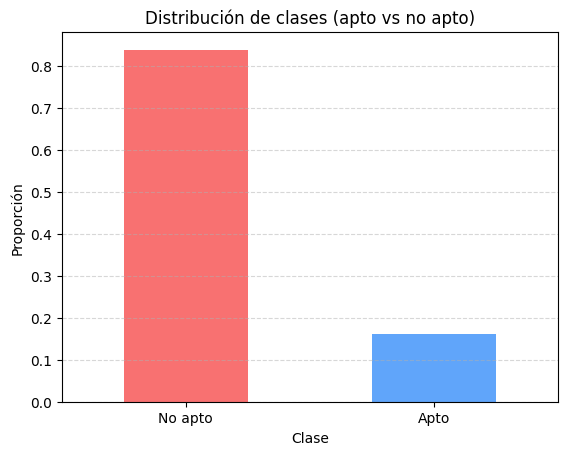

In [60]:
# Mostrar balance de clases
df_numericos['apto'].value_counts(normalize=True).plot(kind='bar', color=['#f87171', '#60a5fa'])
plt.title('Distribución de clases (apto vs no apto)')
plt.xlabel('Clase')
plt.ylabel('Proporción')
plt.xticks([0, 1], ['No apto', 'Apto'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### Columnas de texto

In [33]:
# Selección de columnas de texto relevantes para el análisis nutricional
columnas_texto = [
    'product_name',
    'ingredients_text',
    'categories',
    'main_category', 
    'nutrition_grade_fr',
    'serving_size',
    'countries_en',
    'created_datetime',
]

In [34]:
# Se crea una copia del DataFrame
df_textos = df_procesados[columnas_texto].copy()

In [35]:
df_textos.head()

,product_name,ingredients_text,categories,main_category,nutrition_grade_fr,serving_size,countries_en,created_datetime
0,Chaussons tressés aux pommes,"Ingrédients : Pâte (farine, margarines d'huile...","Snacks sucrés,Biscuits et gâteaux,Pâtisseries",en:sugary-snacks,c,150 g / 1 chausson,Canada,2017-01-15T17:32:08Z
1,Root Beer,"Eau gazéifiée, sirop de maïs à haute teneur en...","Boissons,Boissons gazeuses,Sodas,Boissons sucr...",en:beverages,e,33 cl,France,2015-01-01T22:09:53Z
2,"Pepsi, Nouveau goût !","Eau gazéifiée, sucre, colorant caramel E150d, ...",Sodas au cola,en:beverages,e,150ml,France,2012-08-15T09:48:28Z
3,Madeleines nature,"Farine de _blé_, huile de colza, sucre, _oeufs...","Snacks sucrés,Desserts,Biscuits et gâteaux,Gât...",en:sugary-snacks,d,17.6g,France,2016-10-20T07:19:01Z
4,Cakes aux Fruits,"Fruits 37.4% [fruits confits 21,5% [fruits (pa...","Snacks sucrés,Desserts,Biscuits et gâteaux,Gât...",en:sugary-snacks,d,30 g,France,2016-07-08T21:55:54Z


In [36]:
df_textos.dtypes

product_name          object
ingredients_text      object
categories            object
main_category         object
nutrition_grade_fr    object
serving_size          object
countries_en          object
created_datetime      object
dtype: object

In [37]:
# Identificación de valores nulos para las variables categóricas
for col in df_textos[columnas_texto]:
    print (col, np.sum(pd.isnull(df_textos[col])))

product_name 0
ingredients_text 376
categories 0
main_category 0
nutrition_grade_fr 65
serving_size 1987
countries_en 3
created_datetime 1


In [38]:
# Selección de columnas de texto relevantes para el análisis nutricional eliminado las que no dan releevancia
columnas_texto_limpia = [
    'product_name',
    'ingredients_text',
    'categories',
    'main_category', 
    'nutrition_grade_fr',
    'countries_en',
]

In [39]:
df_textos_limpio = df_procesados[columnas_texto_limpia].copy()

In [40]:
# Rellenar con 'desconocido' donde aplique
df_textos_limpio[columnas_texto_limpia] = df_textos_limpio[columnas_texto_limpia].fillna('desconocido')

In [41]:
# Identificación de valores nulos para las variables categóricas
for col in df_textos_limpio[columnas_texto_limpia]:
    print (col, np.sum(pd.isnull(df_textos_limpio[col])))

product_name 0
ingredients_text 0
categories 0
main_category 0
nutrition_grade_fr 0
countries_en 0


In [42]:
# Aplicar limpieza de campos de texto
for col in columnas_texto_limpia:
    df_textos_limpio[col] = df_textos_limpio[col].apply(limpiar_texto)

In [43]:
df_textos.head(10)

,product_name,ingredients_text,categories,main_category,nutrition_grade_fr,serving_size,countries_en,created_datetime
0,Chaussons tressés aux pommes,"Ingrédients : Pâte (farine, margarines d'huile...","Snacks sucrés,Biscuits et gâteaux,Pâtisseries",en:sugary-snacks,c,150 g / 1 chausson,Canada,2017-01-15T17:32:08Z
1,Root Beer,"Eau gazéifiée, sirop de maïs à haute teneur en...","Boissons,Boissons gazeuses,Sodas,Boissons sucr...",en:beverages,e,33 cl,France,2015-01-01T22:09:53Z
2,"Pepsi, Nouveau goût !","Eau gazéifiée, sucre, colorant caramel E150d, ...",Sodas au cola,en:beverages,e,150ml,France,2012-08-15T09:48:28Z
3,Madeleines nature,"Farine de _blé_, huile de colza, sucre, _oeufs...","Snacks sucrés,Desserts,Biscuits et gâteaux,Gât...",en:sugary-snacks,d,17.6g,France,2016-10-20T07:19:01Z
4,Cakes aux Fruits,"Fruits 37.4% [fruits confits 21,5% [fruits (pa...","Snacks sucrés,Desserts,Biscuits et gâteaux,Gât...",en:sugary-snacks,d,30 g,France,2016-07-08T21:55:54Z
5,Financiers aux Amandes,"Sucre, blanc d’_œufs_ frais, poudre d’_amande_...","Snacks sucrés,Biscuits et gâteaux,Desserts,Gât...",en:sugary-snacks,e,22 g,France,2016-11-30T21:30:44Z
6,Fondants Citron,"Sucre, blanc d’_œufs_ frais, poudre d’_amande_...","Snacks sucrés,Biscuits et gâteaux,Desserts,Gât...",en:sugary-snacks,e,22 g,France,2016-12-01T19:59:24Z
7,Sour Fruit Gummies,"sugar, corn syrup, white grape juice from conc...","Sugary snacks,Confectioneries,Candies",en:sugary-snacks,d,40 g,Germany,2014-01-02T17:03:07Z
8,Jelly Fish,"sugar, corn syrup, modified corn starch, citri...","Sugary snacks,Confectioneries,Candies",en:sugary-snacks,c,40 g,Germany,2014-01-02T11:21:51Z
9,All Butter Cookies Belgian Chocolate Chunk,"Wheatflour contains Gluten (With Wheatflour, C...",Cookies au chocolat,en:sugary-snacks,e,23 g,France,2017-06-23T17:00:33Z


### Unir dataframe

In [44]:
# Construcción del DataFrame final para modelado unificando datos numéricos y categóricos
df_modelo = pd.concat([df_numericas_scaled, df_textos_limpio], axis=1)

In [45]:
df_modelo.head()

,sugars_100g,carbohydrates_100g,fiber_100g,fat_100g,saturated-fat_100g,proteins_100g,salt_100g,sodium_100g,energy_100g,nutrition-score-fr_100g,additives_n,product_name,ingredients_text,categories,main_category,nutrition_grade_fr,countries_en
0,0.054368,-0.473482,-0.442128,-0.696587,-0.851883,-0.611148,-0.037522,-0.037453,-0.840072,-0.642426,0.847150,chaussons tresses aux pommes,ingredients pate farine margarines dhuile de p...,snacks sucres biscuits et gateaux patisseries,en sugary snacks,c,canada
1,-0.521366,-1.561592,-0.944768,-1.556426,-1.117757,-1.166692,-0.096418,-0.096432,-2.072199,0.503056,0.118937,root beer,eau gazeifiee sirop de mais a haute teneur en ...,boissons boissons gazeuses sodas boissons sucr...,en beverages,e,france
2,-0.687344,-1.730360,-0.944768,-1.556426,-1.117757,-1.166692,-0.100060,-0.100061,-2.125709,-0.133323,-0.245170,pepsi nouveau gout,eau gazeifiee sucre colorant caramel e d acidi...,sodas au cola,en beverages,e,france
3,0.121796,0.250444,-0.567788,0.291825,-0.785414,-0.165711,-0.036215,-0.036216,0.300527,-0.260599,0.847150,madeleines nature,farine de ble huile de colza sucre oeufs frais...,snacks sucres desserts biscuits et gateaux gat...,en sugary snacks,d,france
4,0.536739,0.472507,-0.567788,-0.351045,-0.851883,-0.349224,-0.042251,-0.042252,-0.023347,-0.260599,3.031790,cakes aux fruits,fruits fruits confits fruits pasteque bigarrea...,snacks sucres desserts biscuits et gateaux gat...,en sugary snacks,d,france


## Visualizacion

In [48]:
# Filtrar solo columnas nutricionales
cols = ['sugars_100g', 
        'fat_100g', 
        'saturated-fat_100g', 
        'carbohydrates_100g', 
        'fiber_100g', 
        'proteins_100g', 
        'salt_100g', 
        'sodium_100g']
df_nutricionales = df_modelo[cols]


In [49]:
# Estadísticas descriptivas
display(df_nutricionales.describe())

,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,6.337000e+03,6.337000e+03,6.337000e+03,6.337000e+03,6337.000000,6.337000e+03,6.337000e+03,6.337000e+03
mean,5.382050e-17,-2.107970e-16,-8.073075e-17,-1.323087e-16,0.000000,2.691025e-17,1.794017e-17,-2.242521e-18
std,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079,1.000079e+00,1.000079e+00,1.000079e+00
min,-1.226770e+00,-1.556426e+00,-1.117757e+00,-2.192252e+00,-0.944768,-1.166692e+00,-1.026154e-01,-1.026162e-01
25%,-1.014112e+00,-7.849817e-01,-8.518829e-01,-4.734824e-01,-0.567788,-3.659073e-01,-8.752428e-02,-8.752526e-02
50%,1.806013e-02,5.074920e-02,-2.536663e-01,2.948564e-01,-0.215939,-9.897921e-02,-5.029955e-02,-5.030089e-02
75%,6.560356e-01,6.936191e-01,7.433614e-01,6.945702e-01,0.236437,1.846319e-01,-3.983018e-04,-4.001016e-04
max,3.908154e+00,3.988328e+00,6.003679e+00,2.217924e+00,14.134451,4.971649e+01,6.506077e+01,6.506016e+01


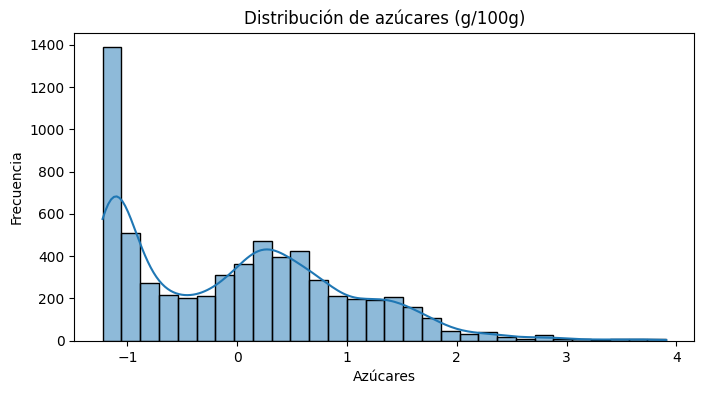

In [50]:
# Histograma de azúcares
plt.figure(figsize=(8,4))
sns.histplot(df_nutricionales['sugars_100g'].dropna(), kde=True, bins=30)
plt.title('Distribución de azúcares (g/100g)')
plt.xlabel('Azúcares')
plt.ylabel('Frecuencia')
plt.show()


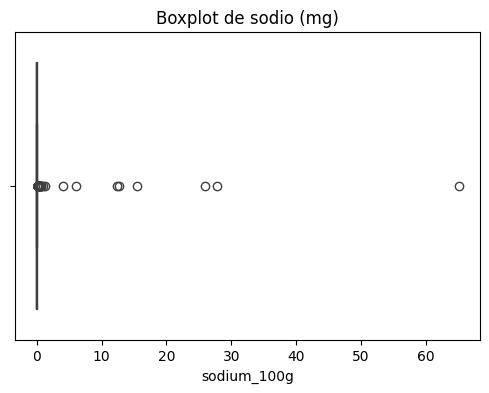

In [51]:
# Boxplot de sodio
plt.figure(figsize=(6,4))
sns.boxplot(x=df_nutricionales['sodium_100g'])
plt.title('Boxplot de sodio (mg)')
plt.show()

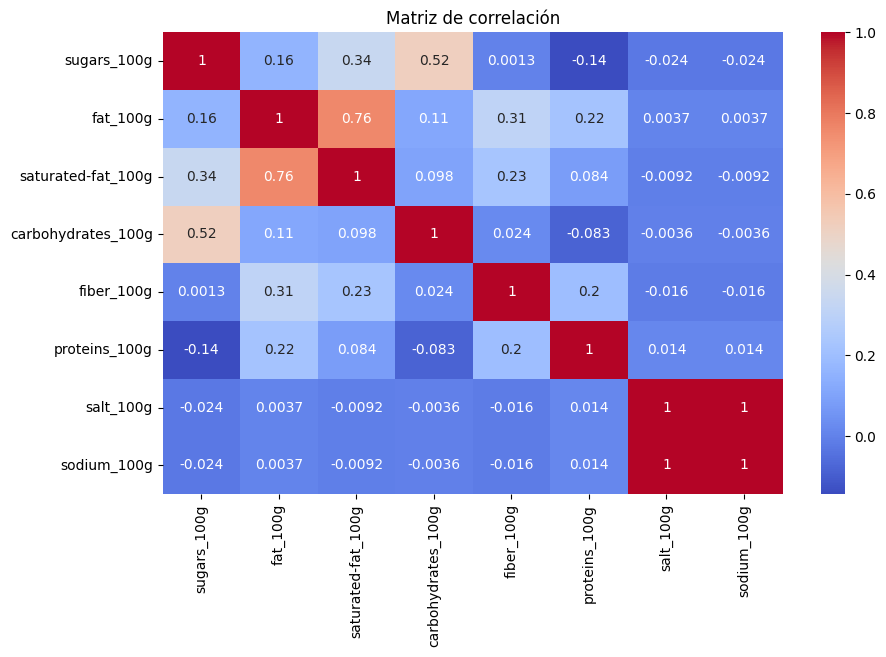

In [52]:
# Matriz de correlación
plt.figure(figsize=(10,6))
corr = df_nutricionales.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

## Guardar dataset preparado

In [47]:
# Guarda el dataset preparado en formato csv
df_modelo.to_csv('dataset/openfoodfacts_preparado.csv', index=False)